# Série temporelle : décomposition par méthode de Buys Ballot et approximation de la perturbation par un modèle AR

In [186]:
import pandas as pd # pour les séries temporelles
import matplotlib.pyplot as plt # pour les plot
import numpy as np
from copy import deepcopy
from BuysBallot import BuysBallotModel  # module python pour la méthode de Buys Ballot
from datetime import datetime  # gestion des dates
import scipy.stats  # outils statistiques
import statsmodels.api as sm # outils pour les séries temporelles

In [187]:
path = "Data/ukcp09_gridded-land-obs-daily_timeseries_mean-temperature_000000E_500000N_19600101-20161231.csv"
data = pd.read_csv(path, header=[0,1], index_col=0, parse_dates=True)

In [188]:
data.head()

easting,22500,27500,32500,37500,42500,47500,27500,32500,37500,42500,...,37500,42500,47500,17500,22500,27500,32500,37500,42500,47500
northing,547500,547500,547500,547500,547500,547500,542500,542500,542500,542500,...,507500,507500,507500,502500,502500,502500,502500,502500,502500,502500
1960-01-01,6.20,6.40,6.94,7.14,7.15,7.23,5.87,6.01,6.46,6.67,...,6.44,6.22,6.62,6.11,7.09,7.00,6.74,6.73,6.74,6.84
1960-01-02,4.53,4.58,4.81,4.90,4.90,5.06,4.20,4.24,4.51,4.66,...,4.05,3.97,4.38,4.40,4.82,4.66,4.38,4.36,4.43,4.65
1960-01-03,8.48,8.51,8.72,8.70,8.49,8.39,8.18,8.12,8.29,8.23,...,8.75,8.44,8.67,8.96,9.58,9.43,9.09,8.97,8.87,8.90
1960-01-04,7.02,7.09,7.31,7.34,7.27,7.34,6.83,6.85,7.05,7.10,...,7.39,7.14,7.34,7.51,8.04,7.94,7.67,7.56,7.50,7.54
1960-01-05,2.49,2.74,3.31,3.49,3.52,3.59,2.40,2.57,2.95,3.12,...,4.02,3.54,3.59,2.94,4.20,4.26,4.09,3.97,3.81,3.63


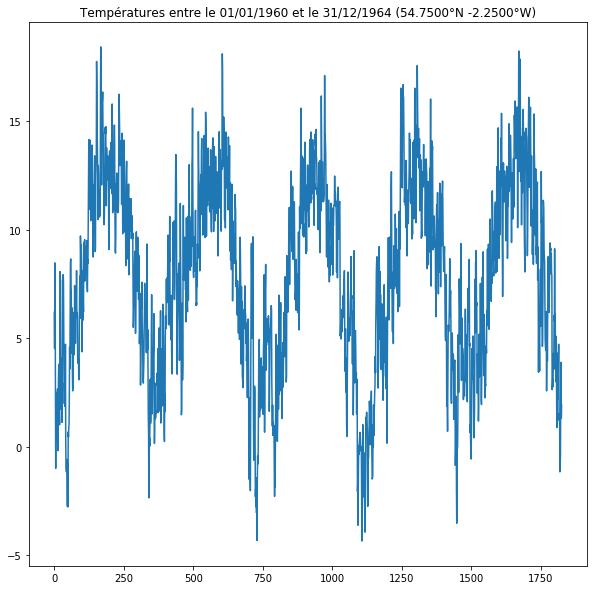

In [189]:
# Suppression des relevés pour les 29/02 des années bissextiles
data = pd.read_csv(path, header=[0,1], index_col=0, parse_dates=True)
dates_to_remove = [datetime.date(datetime.strptime(str(y)+"-02-29", '%Y-%m-%d')) for y in range(1960, 2017, 4)]
data = data.drop(dates_to_remove)

# sélection d'une série temporelle (un lieu)
series = data["22500"]["547500"]
sup = len(series)-1
inf = 0
dates = data.index

# plot
plt.figure(figsize=(10,10))
plt.plot(list(series[:365*5]))
plt.title("Températures entre le 01/01/1960 et le 31/12/1964 (54.7500°N -2.2500°W)")
plt.show()

In [190]:
# Définition des fonctions de base pour la régression
def f2(t, i, j, length, subd = 1):
    return np.power(t,i) * (t>=j*length/subd).astype(int)*(t<(j+1)*length/subd).astype(int)


def g(t, i, k = 365):
    return (t%k == i).astype(int) - (t%k == 0).astype(int)

In [191]:
# Méthode de Buys Ballot
BBM = BuysBallotModel(f2, g, subd=1, dim=2)

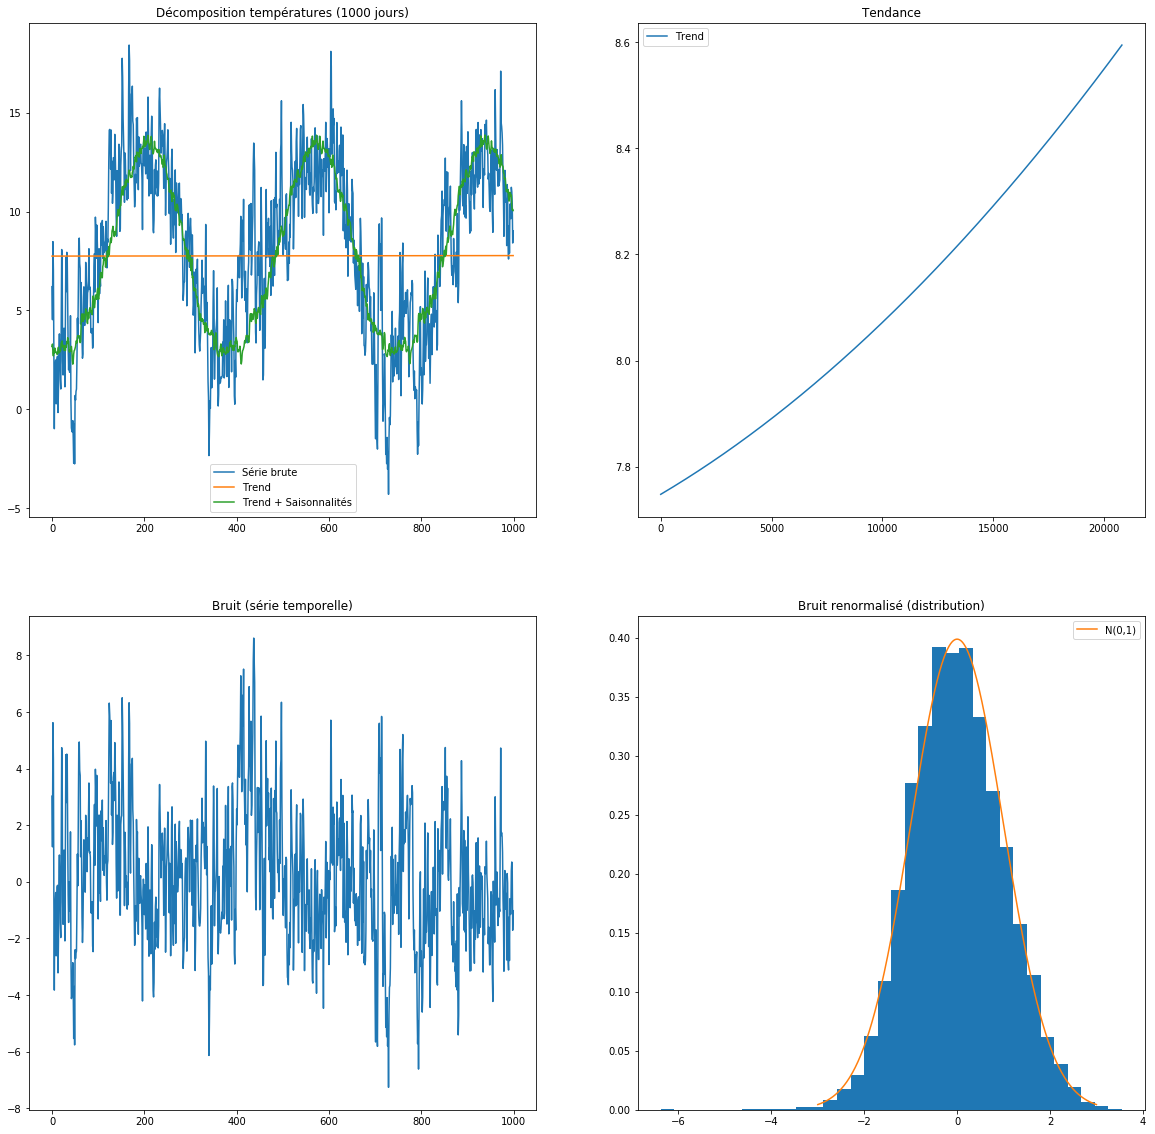

In [192]:
BBM.plot_decomposition(data,"22500", "547500")

In [194]:
# Lecture de la série des résidus (enregistrée indépendemment)
filename = "BB22500-547500.csv"
path_noise = "Decomposition/Noise/"
serie = pd.read_csv(path_noise + filename, header=None)[1]
serie.index = data.index
serie

1960-01-01    3.027063
1960-01-02    1.235675
1960-01-03    5.623936
1960-01-04    4.325355
1960-01-05   -0.510594
1960-01-06   -3.827771
1960-01-07   -0.896176
1960-01-08   -0.714056
1960-01-09   -0.379303
1960-01-10   -2.616656
1960-01-11   -1.474184
1960-01-12   -0.181361
1960-01-13   -0.124328
1960-01-14   -3.219575
1960-01-15   -2.104823
1960-01-16    0.343789
1960-01-17    0.947489
1960-01-18    0.125926
1960-01-19   -1.452830
1960-01-20   -1.970885
1960-01-21    1.235096
1960-01-22    4.740726
1960-01-23    4.144952
1960-01-24   -0.717313
1960-01-25   -1.502736
1960-01-26   -1.030089
1960-01-27    1.122909
1960-01-28    0.625557
1960-01-29   -2.090217
1960-01-30    1.486465
                ...   
2016-12-02   -3.026458
2016-12-03   -2.588404
2016-12-04   -2.035788
2016-12-05    0.349460
2016-12-06    2.833128
2016-12-07    7.006797
2016-12-08    5.185553
2016-12-09    4.765011
2016-12-10    2.987627
2016-12-11    1.567085
2016-12-12    1.826894
2016-12-13    3.783895
2016-12-14 

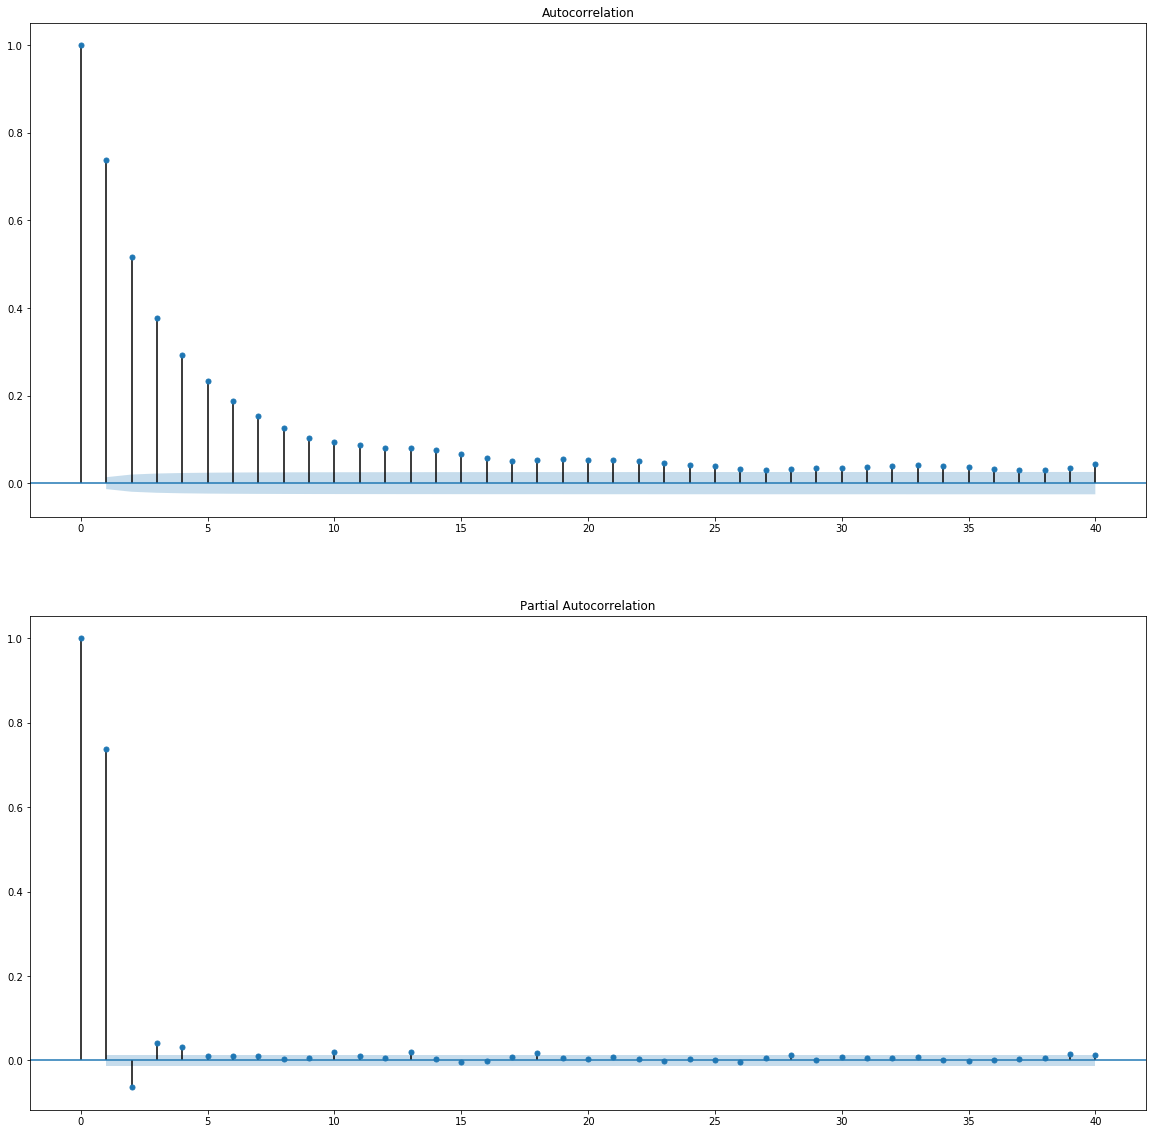

In [195]:
# Autocorrélation et autocorrélation partielle
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(serie, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(serie, lags=40, ax=ax2)

In [196]:
# Modèle ARMA
model1 = sm.tsa.ARMA(serie, (4,0))
result1 = model1.fit(disp=False)

/media/pub/coudray/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/media/pub/coudray/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


In [197]:
result1.params

const      0.001182
ar.L1.1    0.787050
ar.L2.1   -0.093212
ar.L3.1    0.015698
ar.L4.1    0.032850
dtype: float64

In [198]:
confidence = result1.conf_int(alpha=0.05)
print((confidence[1]-confidence[0])/2)

/media/pub/coudray/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/media/pub/coudray/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


const      0.087247
ar.L1.1    0.013582
ar.L2.1    0.017288
ar.L3.1    0.017291
ar.L4.1    0.013585
dtype: float64


In [199]:
model1.loglike(result1.params)

/media/pub/coudray/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


-39994.291438203596

In [200]:
result1.pvalues

const      9.788182e-01
ar.L1.1    0.000000e+00
ar.L2.1    4.908733e-26
ar.L3.1    7.517788e-02
ar.L4.1    2.158948e-06
dtype: float64

/media/pub/coudray/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


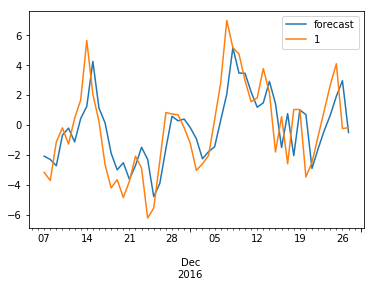

In [202]:
result1.plot_predict(20750,20800)
plt.show()

/media/pub/coudray/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


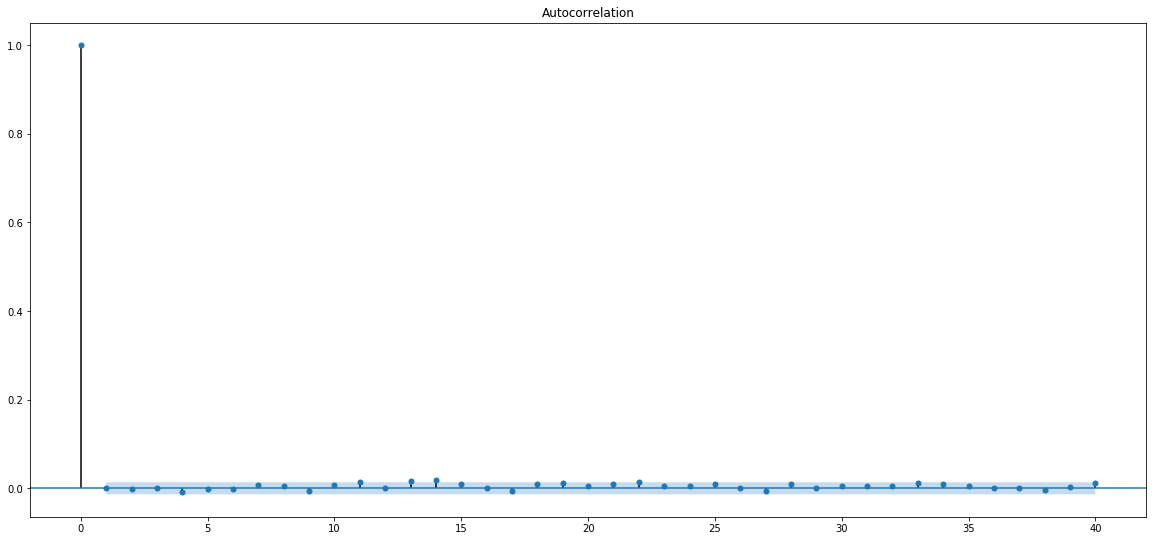

In [203]:
# Résidus -> bruit blanc ?
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(result1.resid, lags=40, ax=ax1, alpha=0.05)

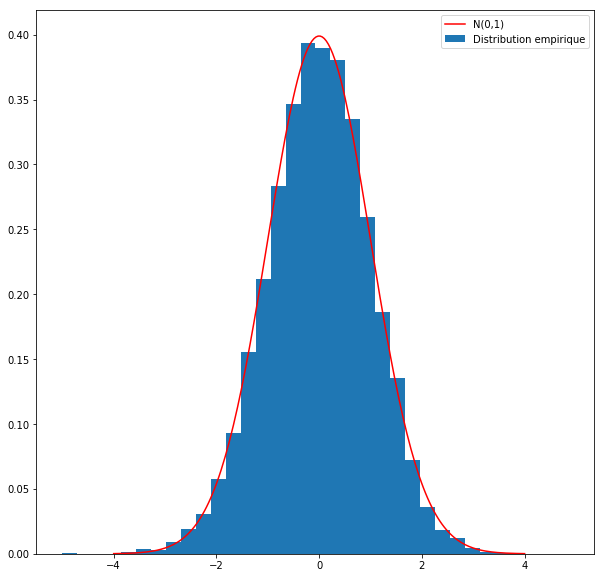

In [205]:
# Normalité de la distribution des résidus ?
normalized_resid = result1.resid/np.std(result1.resid)
x = np.linspace(-4,4,200)
plt.figure(figsize=(10,10))
plt.hist(normalized_resid.values, bins = int((2*len(normalized_resid))**(1/3)), normed=True, label="Distribution empirique")
plt.plot(x, scipy.stats.norm.pdf(x), color = 'r', label = "N(0,1)")
plt.legend()
plt.show()

In [207]:
# Test de Kolmogorov-Smirnov
r = scipy.stats.kstest(normalized_resid, "norm")
r

KstestResult(statistic=0.006439364516967805, pvalue=0.354199984528369)